
Copyright 2021 DeepMind Technologies Limited

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Machine Learning in Knot Theory

# Invariants Mapping


DeepMind. “Advancing Mathematics by Guiding Human Intuition with AI.” Nature 600, no. 7887 (December 2021): 70–74.

Craven, Jessica, Mark Hughes, Vishnu Jejjala, and Arjun Kar. “Learning Knot Invariants across Dimensions.” ArXiv:2112.00016.

Craven, Jessica, Mark Hughes, Vishnu Jejjala, and Arjun Kar. “(K)Not Machine Learning.” ArXiv:2201.08846.


In [1]:
# @title Imports
import tempfile

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# @title Download data

_, input_filename = tempfile.mkstemp()
!gsutil cp "gs://maths_conjectures/knot_theory/knot_theory_invariants.csv" {input_filename}

full_df = pd.read_csv(input_filename)

In [3]:
# @title Load and preprocess data

#@markdown The columns of the dataset which will make up the inputs to the network.
#@markdown In other words, for a knot k, X(k) will be a vector consisting of these quantities. In this case, these are the geometric invariants of each knot.
#@markdown For descriptions of these invariants see https://knotinfo.math.indiana.edu/
display_name_from_short_name = {
    'chern_simons': 'Chern-Simons',
    'cusp_volume': 'Cusp volume',
    'hyperbolic_adjoint_torsion_degree': 'Adjoint Torsion Degree',
    'hyperbolic_torsion_degree': 'Torsion Degree',
    'injectivity_radius': 'Injectivity radius',
    'longitudinal_translation': 'Longitudinal translation',
    'meridinal_translation_imag': 'Re(Meridional translation)',
    'meridinal_translation_real': 'Im(Meridional translation)',
    'short_geodesic_imag_part': 'Im(Short geodesic)',
    'short_geodesic_real_part': 'Re(Short geodesic)',
    'Symmetry_0': 'Symmetry: $0$',
    'Symmetry_D3': 'Symmetry: $D_3$',
    'Symmetry_D4': 'Symmetry: $D_4$',
    'Symmetry_D6': 'Symmetry: $D_6$',
    'Symmetry_D8': 'Symmetry: $D_8$',
    'Symmetry_Z/2 + Z/2': 'Symmetry: $\\frac{Z}{2} + \\frac{Z}{2}$',
    'volume': 'Volume',
}
column_names = list(display_name_from_short_name)
target = 'signature'

#@markdown Split the data into a training, a validation and a holdout test set. To check
#@markdown the robustness of the model and any proposed relationship, the training
#@markdown process can be repeated with multiple different train/validation/test splits.

random_seed = 2 # @param {type: "integer"}
random_state = np.random.RandomState(random_seed)
train_df, validation_and_test_df = train_test_split(
    full_df, random_state=random_state)
validation_df, test_df = train_test_split(
    validation_and_test_df, test_size=.5, random_state=random_state)

# Find bounds for the signature in the training dataset.
max_signature = train_df[target].max()
min_signature = train_df[target].min()

In [4]:
# @title Network Definition

#@markdown Create a simple feedforward network, using the DM Haiku library
#@markdown (https://github.com/deepmind/dm-haiku).

#@markdown The output of the network is a predicted categorical distribution, represented
#@markdown by a vector q, where softmax(q)[i] is the predicted probability that the
#@markdown signature of the knot is equal to 2*i + min_signature. Note that signature is
#@markdown always an even integer.

#@markdown We take the cross entropy between this distribution and the true distribution
#@markdown (i.e. 1 at the true value of the signature, 0 everywhere else) as the loss
#@markdown function.


def net_forward(inp):
  return hk.Sequential([
      hk.Linear(300),
      jax.nn.sigmoid,
      hk.Linear(300),
      jax.nn.sigmoid,
      hk.Linear(300),
      jax.nn.sigmoid,
      hk.Linear(int((max_signature - min_signature) / 2)),
  ])(
      inp)


def softmax_cross_entropy(logits, labels):
  # Labels are the true values of the signature
  one_hot = jax.nn.one_hot((labels - min_signature) / 2, logits.shape[-1])
  return -jnp.sum(jax.nn.log_softmax(logits) * one_hot, axis=-1)


# The cross-entropy loss is composed with the network predictions, to define
# `loss_fn` as a function on X and y.
def loss_fn(inputs, labels):
  return jnp.mean(softmax_cross_entropy(net_forward(inputs), labels))


# Haiku network transformation steps.
loss_fn_t = hk.without_apply_rng(hk.transform(loss_fn))
net_forward_t = hk.without_apply_rng(hk.transform(net_forward))


@jax.jit
def predict(params, data_X):
  return (np.argmax(net_forward_t.apply(params, data_X), axis=1) * 2 +
          min_signature)


#@markdown Calculate the mean and standard deviation over each column in the training
#@markdown dataset. We use this to normalize each feature, this is best practice for
#@markdown inputting features into a network, but is also very important in this case
#@markdown to ensure the gradients used for saliency are meaningfully comparable.
def normalize_features(df, cols, add_target=True):
  features = df[cols]
  sigma = features.std()
  if any(sigma == 0):
    print(sigma)
    raise RuntimeError(
        "A poor data stratification has led to no variation in one of the data "
        "splits for at least one feature (ie std=0). Restratify and try again.")
  mu = features.mean()
  normed_df = (features - mu) / sigma
  if add_target:
    normed_df[target] = df[target]
  return normed_df


def get_batch(df, cols, size=None):
  batch_df = df if size is None else df.sample(size)
  X = batch_df[cols].to_numpy()
  y = batch_df[target].to_numpy()
  return X, y


normed_train_df = normalize_features(train_df, column_names)
normed_validation_df = normalize_features(validation_df, column_names)
normed_test_df = normalize_features(test_df, column_names)

In [5]:
# @title Network Setup (re-run before re-training)

batch_size = 64
learning_rate = 0.001
num_training_steps = 10_000
validation_interval = 100

train_X, train_y = get_batch(normed_train_df, column_names, batch_size)

# Pick a random seed for the network weights. To check the robustness of the
# model, the training process can be repeated with multiple different random
# seeds.
rng = jax.random.PRNGKey(1)
init_params = loss_fn_t.init(rng, train_X, train_y)

opt_init, opt_update = optax.adam(learning_rate)
opt_state = opt_init(init_params)

/Users/spencer/opt/miniconda3/envs/KnotML/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:1923: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "zeros")


In [6]:
# @title Network Training

# We train until the validation loss stops decreasing, checking every <validation_interval> steps,
# up to a maximum of 10k steps.


@jax.jit
def update(params, opt_state, batch_X, batch_y):
  grads = jax.grad(loss_fn_t.apply)(params, batch_X, batch_y)
  upds, new_opt_state = opt_update(grads, opt_state)
  new_params = optax.apply_updates(params, upds)
  return new_params, new_opt_state


def train(columns_to_train_on, params, opt_state, update_fn):
  best_validation_loss = np.inf
  for i in range(num_training_steps):
    train_X, train_y = get_batch(normed_train_df, columns_to_train_on,
                                 batch_size)
    params, opt_state = update_fn(params, opt_state, train_X, train_y)

    if i % validation_interval == 0:
      # Run validation on the full validation dataset.
      validation_X, validation_y = get_batch(normed_validation_df,
                                             columns_to_train_on)
      train_loss = loss_fn_t.apply(params, train_X, train_y)
      validation_loss = loss_fn_t.apply(params, validation_X, validation_y)
      print(f"Step count: {i}")
      print(f"Train loss: {train_loss}")
      print(f"Validation loss: {validation_loss}")

      if validation_loss > best_validation_loss:
        print("Validation loss increased. Stopping!")
        return params
      else:
        best_validation_loss = validation_loss
  return params


trained_params = train(column_names, init_params, opt_state, update)
# Print the test accuracy, i.e. the proportion of the knots for which the
# network predicts the correct signature.
test_X, test_y = get_batch(normed_test_df, column_names)

# The final below accuracy should be in the low 80%s.
print("Test Accuracy: ",
      np.mean((predict(trained_params, test_X) - test_y) == 0))

/Users/spencer/opt/miniconda3/envs/KnotML/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


Step count: 0
Train loss: 2.2228240966796875
Validation loss: 2.3569633960723877
Step count: 100
Train loss: 0.9520544409751892
Validation loss: 1.0241776704788208
Step count: 200
Train loss: 0.5086336135864258
Validation loss: 0.549424409866333
Step count: 300
Train loss: 0.479158878326416
Validation loss: 0.5028249621391296
Step count: 400
Train loss: 0.3151282072067261
Validation loss: 0.454672634601593
Step count: 500
Train loss: 0.3594265580177307
Validation loss: 0.4285248816013336
Step count: 600
Train loss: 0.43525710701942444
Validation loss: 0.4117538332939148
Step count: 700
Train loss: 0.335663378238678
Validation loss: 0.3942384421825409
Step count: 800
Train loss: 0.3683132529258728
Validation loss: 0.4027230739593506
Validation loss increased. Stopping!
Test Accuracy:  0.8335686


The below cell replicates Figure 2a from the paper, though for simplicity omitting the error bars.

To compute the saliency, we take the gradient of the loss function, with respect to each of the the components of the X input to the network (i.e. the geometric invariants of each knot), and average over the dataset.

We plot the feature saliencies in decreasing order. The plot (should!) show that the overall loss is influenced far more by the longitudinal translation and the real and imaginary parts of the meridional translation than any of the other invariants.

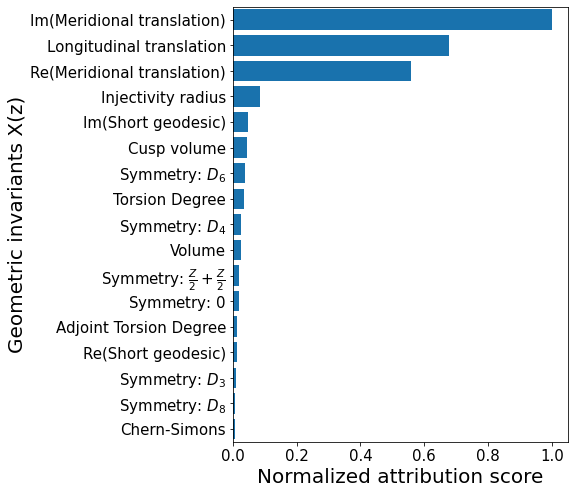

In [7]:
# @title Saliency Analysis
train_X = normalize_features(train_df, column_names, add_target=False).to_numpy()
train_y = train_df[target].to_numpy()


saliencies = np.mean(
    np.abs(jax.grad(loss_fn_t.apply, 1)(trained_params, train_X, train_y)), axis=0)


decreasing_saliency = reversed(sorted(zip(saliencies, display_name_from_short_name.values())))
sorted_saliencies, sorted_columns = zip(*decreasing_saliency)

fig, ax = plt.subplots(figsize=(6,8))
sns.barplot(y=np.array(sorted_columns),
            x=np.array(sorted_saliencies) / max(sorted_saliencies),
            color="#0077c6");

ax.tick_params(labelsize=15);
ax.set_ylabel('Geometric invariants X(z)', fontsize=20);
plt.xlabel('Normalized attribution score', fontsize=20);

In [8]:
# @title Confirming the Feature Saliency

#@markdown To confirm the results of the saliency analysis, we re-train the network with
#@markdown only these three features as input to the network.
salient_column_names = ['longitudinal_translation',
                        'meridinal_translation_imag',
                        'meridinal_translation_real']
target = 'signature'

In [9]:
# @title Confirming the Feature Saliency: Network Setup (re-run before re-training)

train_X, train_y = get_batch(normed_train_df, salient_column_names, batch_size)

init_params_salient = loss_fn_t.init(rng, train_X, train_y)

opt_init_salient, opt_update_salient = optax.adam(learning_rate)
opt_state_salient = opt_init(init_params_salient)

/Users/spencer/opt/miniconda3/envs/KnotML/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:1923: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "zeros")


In [10]:
# @title Confirming the Feature Saliency: Network Training


#@markdown Re-train the network using only the most salient features.
@jax.jit
def update_salient(params, opt_state, batch_X, batch_y):
  grads = jax.grad(loss_fn_t.apply)(params, batch_X, batch_y)
  upds, new_opt_state = opt_update_salient(grads, opt_state)
  new_params = optax.apply_updates(params, upds)
  return new_params, new_opt_state


trained_params_salient = train(salient_column_names, init_params_salient,
                               opt_state_salient, update_salient)

#@markdown Print the test accuracy. This should be very similar to the test accuracy in
#@markdown the case that all columns / invariants are included, demonstrating that most
#@markdown of the predictve information about the signature is contained in the three
#@markdown selected invariants.
test_X, test_y = get_batch(normed_test_df, salient_column_names)

#@markdown The final below accuracy should be in the low 80%s, probably 0.8 -> 0.85
print("Test Accuracy: ",
      np.mean((predict(trained_params_salient, test_X) - test_y) == 0))

/Users/spencer/opt/miniconda3/envs/KnotML/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


Step count: 0
Train loss: 2.308607578277588
Validation loss: 2.3246474266052246
Step count: 100
Train loss: 0.7424849271774292
Validation loss: 0.6504075527191162
Step count: 200
Train loss: 0.5295721292495728
Validation loss: 0.51653653383255
Step count: 300
Train loss: 0.513279914855957
Validation loss: 0.4616980254650116
Step count: 400
Train loss: 0.41631072759628296
Validation loss: 0.4461582899093628
Step count: 500
Train loss: 0.4315899610519409
Validation loss: 0.42861247062683105
Step count: 600
Train loss: 0.5489653944969177
Validation loss: 0.42964744567871094
Validation loss increased. Stopping!
Test Accuracy:  0.8233286


In [11]:
# @title Slope vs. Signature: Proposed Linear Relationship

#@markdown The quantity we proposed was the "natural slope", given by
#@markdown real(longitudinal_translation / meridinal_translation). We show that
#@markdown this is approximately twice the signature (up to a correction term based on
#@markdown other hyperbolic invariants) which we can check by comparing the predictions
#@markdown made by this rule to those made by the previously trained models.


def predict_signature_from_slope(data_X, min_signature, max_signature):
  meridinal_translation = (
      data_X['meridinal_translation_real'] +
      1j * data_X['meridinal_translation_imag'])
  slope = data_X['longitudinal_translation'] / meridinal_translation
  return slope.real / 2

Text(0, 0.5, 'Signature')

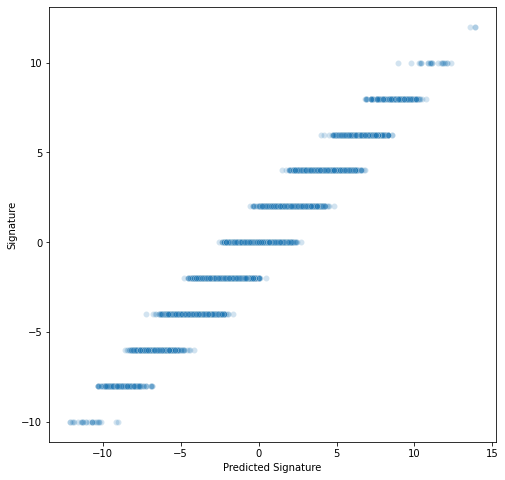

In [12]:
# @title Proposed Linear Relationship: Scatter plot

#@markdown Scatter plot of the slope against predicted signature.
predictions = [
    predict_signature_from_slope(x, min_signature, max_signature)
    for _, x in test_df.iterrows()
]

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x=predictions, y=test_df[target], alpha=0.2)
ax.set_xlabel('Predicted Signature')
ax.set_ylabel('Signature')

In [13]:
# @title Proposed Linear Relationship: Test Accuracy


#@markdown In order to compute the "test accuracy" in the same way as before, we quantize
#@markdown the predicted signature values to even integers, between min_signature and
#@markdown max_signature.
def quantize(x, min_signature, max_signature):
  return min(max(2 * round(x / 2), min_signature), max_signature)


quantized_predictions = [
    quantize(x, min_signature, max_signature) for x in predictions
]

Now we can compute the "test accuracy" of this prediction.

The value is slightly lower than for the trained network predictors (although still far higher than chance), but this is not unexpected.

Indeed, the proposed rule gives a provable bound on the signature over all knots, instead of maximizing prediction performance over a given finite dataset, as the networks are doing. Although we do use separate training, validation and test datasets for the networks, these are all drawn from approximately the same distribution, whereas the proposed rule could be considered (in some imprecise sense) to have been "trained" on the set of all knots, a very different distribution.

The correction term may also have some bias, for example tending to be positive more often than it is negative, information which the network predictors would be able to use to increase their prediction performance relative to that of the proposed rule.

In [14]:
#@markdown The below accuracy will probably be lower than the previous ~80%, but not by much, likely still >70%
print("Test Accuracy: ", np.mean(test_df[target] - quantized_predictions == 0))

Test Accuracy:  0.738192917391447
